# Data Collection

In [20]:
import nltk
import random
import numpy as np
import pandas as pd
from nltk.corpus import gutenberg
from nltk.corpus import stopwords


In [21]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# get the book list
bookList = gutenberg.fileids()
print(bookList)

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
books = np.array(bookList[3])
# books = np.append(books, bookList[3])
books = np.append(books, bookList[4])
books = np.append(books, bookList[6])
books = np.append(books, bookList[7])
books = np.append(books, bookList[11])
books = np.append(books, bookList[13])
books = np.append(books, bookList[15])

In [23]:
def sampling(number_samples, sample_size, book_name):
    labeled_records = []
    book = gutenberg.raw(book_name)
    # print(book)
    # tokenize the material of the book
    raw_words = nltk.word_tokenize(book)
    # print(raw_words)
    # Prepare 200 documents for each book
    headers = random.sample(range(0, len(raw_words)), number_samples)

    for header in headers:
        segment = raw_words[header:(header + sample_size + 1)]
        labeled_records.append((segment, book_name))
    return labeled_records

# Data Cleaning

In [24]:
from string import punctuation
from nltk.corpus import gutenberg
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
def data_cleaning(sample_words):
    # customize the punctuation list by adding extra string
    extra_string = "'-- ``'' "
    update_punctuation = punctuation + extra_string
    # customize the stopwords list by adding extra stopwords
    sw = stopwords.words('english')
    extra_stopwords = "n't", "'s", "ar't", "'d", "'ll", "i'll"
    sw.extend(extra_stopwords)
    # Remove punctuation
    remove_punct_words = [w for w in sample_words if w not in update_punctuation]
    # Change all letters to lowercase
    lowercase_words = [w.lower() for w in remove_punct_words]
    # Strip "_" at the beginning or end of a word
    strip_words = [w.strip('_') for w in lowercase_words]
    # Remember digits/numbers (keeps only words)
    remove_number_words = [w for w in strip_words if w.isalpha()]
    # Remove stop words
    final_words = [w for w in remove_number_words if w not in sw]
    return final_words

In [26]:
if __name__ == "__main__":
    try_number_samples = 200
    try_sample_size = 150
    final_list = []
    for book_name in books:
        # print (book_name)
        labeled_list = sampling(try_number_samples, try_sample_size, book_name)
        cleaned_labeled_list = []

        for samples in labeled_list:
            book_name = samples[1]

            cleaned_seg = data_cleaning(samples[0])
            cleaned_labeled_seg = (cleaned_seg, book_name)
            # print(cleaned_labeled_seg)
            cleaned_labeled_list.append(cleaned_labeled_seg)
        # print(cleaned_labeled_list)
        final_list = final_list + cleaned_labeled_list
    # shuffle the list
#     shuffle(final_list)
    #print(final_list)

    docs = []
    tags = []

    # word lemmatization
    lem = WordNetLemmatizer()
    for labeled_doc in final_list:
        docs.append(lem.lemmatize(' '.join(labeled_doc[0])))
        tags.append(labeled_doc[1])
#     print(docs)
    # import data to dictionary
    dic = {'Text': docs, 'File_name': tags}
    # apply pandas data frame
    df = pd.DataFrame(dic)
#     print(df)
    # df.columns = ['Text', 'File_name']
    df['book_id'] = df['File_name'].factorize()[0]
    book_id_df = df[['File_name', 'book_id']].drop_duplicates().sort_values('book_id')
    book_to_id = dict(book_id_df.values)
    id_to_book = dict(book_id_df[['book_id', 'File_name']].values)

    df.to_csv('final_output.csv')
    
    # feature engineering： BOW
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    features = vectorizer.fit_transform(df['Text'])

In [27]:
# dimension reducing
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(features.toarray())

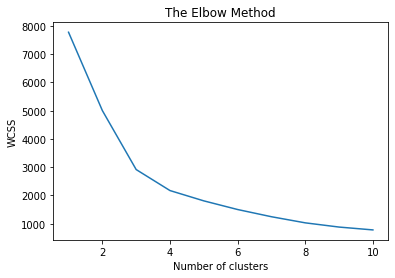

In [28]:
# K-Means Clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Using the elbow method to find the optimal number of clusters (7)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Y_sklearn)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [29]:
#KMeans clustering
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)

KMeans(max_iter=100, n_clusters=4, n_init=1)

In [30]:
kmeans_predict = model.predict(features)
print (kmeans_predict)

[3 3 3 ... 2 2 2]


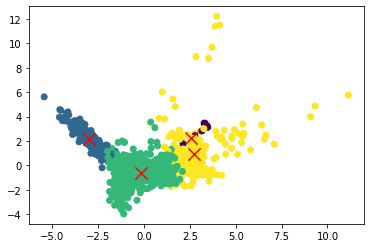

In [31]:
# visualization of KMeans
reduced_cluster_centers = sklearn_pca.transform(model.cluster_centers_)
plt.scatter(Y_sklearn[:,0], Y_sklearn[:,1], c=model.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='r')

In [32]:
# count the ratio of cluster id in each cluster
# return stat - display the predicted clusters' id distribution
# return new_id - the clusters' id array following the original doc order
def statistics(predict):
    stat = []
    new_id = []
    for i in range(0, 1400, 200):
        ratio = []
        most_possible_id = 0
        max_count = 0
        for j in range(7):
            # count = predict[i:i + 200].count(j)
            counter = collections.Counter(predict[i:i + 200])
            count = counter[j]
            ratio.append(count / 200)
            if count > max_count:
                max_count = count
                most_possible_id = j
        stat.append(ratio)
        new_id.append(most_possible_id)
    return stat, new_id

In [33]:
# obtain cluster id from predict result
import collections
stat, new_id = statistics(kmeans_predict)

In [34]:
predict_df = pd.DataFrame(stat, index = books, columns=['0', '1', '2', '3', '4', '5', '6'])
print(predict_df)
new_id

                             0      1      2      3    4    5    6
bible-kjv.txt            0.000  0.000  0.360  0.640  0.0  0.0  0.0
blake-poems.txt          0.055  0.000  0.750  0.195  0.0  0.0  0.0
burgess-busterbrown.txt  0.000  0.835  0.165  0.000  0.0  0.0  0.0
carroll-alice.txt        0.000  0.000  1.000  0.000  0.0  0.0  0.0
edgeworth-parents.txt    0.000  0.000  1.000  0.000  0.0  0.0  0.0
milton-paradise.txt      0.000  0.000  0.805  0.195  0.0  0.0  0.0
shakespeare-hamlet.txt   0.000  0.000  0.890  0.110  0.0  0.0  0.0


[3, 2, 1, 2, 2, 2, 2]

In [35]:
# create new book id
ids = []
for k in new_id:
    arr = np.ones(200)
    ids.append(arr * k)
book_cluster_ids = np.array(ids,dtype='int8').flatten()
# assign new book id to the df
df['cluster_id'] = book_cluster_ids
df.cluster_id


0       3
1       3
2       3
3       3
4       3
       ..
1395    2
1396    2
1397    2
1398    2
1399    2
Name: cluster_id, Length: 1400, dtype: int8

In [36]:
#evaluation of KMeans
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(df.cluster_id, kmeans_predict))

0.659075535512965


In [37]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
print(homogeneity_score(df.book_id, kmeans_predict))
silhouette_score(features, labels=kmeans_predict)

0.23329801439743508


0.03727701329776682

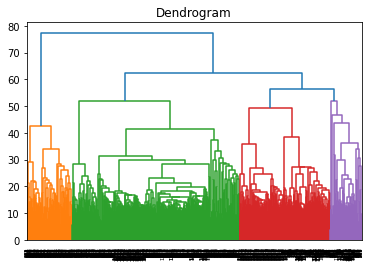

In [38]:
# Using the dendrogram to find the optimal number of clusters (7)
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(features.toarray(), method = 'ward'))
plt.title('Dendrogram')
plt.show()